# 6. Multicategory logit models

## 6.1 Baseline categority logit models

$$
\log \frac{\pi_j}{\pi_c} = \alpha_j + \beta_j x, \quad j = 1, \dots, c-1 
$$

- pick a category and model $\log(\pi_j / \pi_c)$ for all $j \neq c$, where $\pi_c$ corresponds to the chosen ('baseline') category, often the last 
- assuming the last category is chosen as the baseline, there are $c-1$ equations in total, each of which have their own parameters $\alpha_j, \ \beta_j$ 
- any arbitrary ratio $\log(\pi_i / \pi_j)$ can be found, given all $\log(\pi_j/\pi_c)$ are known
  - e.g. $\log(\pi_1/\pi_2) = \log(\pi_1/\pi_c) - \log(\pi_2/\pi_c) = (\alpha_1 - \alpha_2) + (\beta_1-\beta_2)x$

In [11]:
Gators <- read.table(
    "http://www.stat.ufl.edu/~aa/cat/data/Alligators.dat",
    header=TRUE, stringsAsFactors=FALSE
)
head(Gators)

,x,y
,<dbl>,<chr>
1,1.24,I
2,1.30,I
3,1.30,I
4,1.32,F
5,1.32,F
6,1.40,F


We will model preferred diet in column $y$, which contains values F, I, and O, based on corresponding alligator length $x$. We first fit a baseline-category logit model where $Y=O$ is the baseline category.

In [12]:
library(VGAM)
fit <- vglm(
    y ~ x, 
    family=multinomial, 
    data=Gators
)
coef(fit, matrix=TRUE)

,"log(mu[,1]/mu[,3])","log(mu[,2]/mu[,3])"
(Intercept),1.617731,5.697444
x,-0.110109,-2.465446


$$
\begin{align}
    \log(\pi_F/\pi_O) &= 1.618 - 0.110x \\
    \log(\pi_I/\pi_0) &= 5.697 - 2.465x \\
    \log(\pi_F/\pi_I) &= (1.618-5.697) + (-0.110+2.465)x = -4.080 + 2.355x 
\end{align}
$$

In [13]:
summary(fit)


Call:
vglm(formula = y ~ x, family = multinomial, data = Gators)

Coefficients: 
              Estimate Std. Error z value Pr(>|z|)   
(Intercept):1   1.6177     1.3073   1.237  0.21591   
(Intercept):2   5.6974     1.7937   3.176  0.00149 **
x:1            -0.1101     0.5171  -0.213  0.83137   
x:2            -2.4654     0.8996      NA       NA   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Names of linear predictors: log(mu[,1]/mu[,3]), log(mu[,2]/mu[,3])

Residual deviance: 98.3412 on 114 degrees of freedom

Log-likelihood: -49.1706 on 114 degrees of freedom

Number of Fisher scoring iterations: 5 

'x:2'


Reference group is level  3  of the response

Below, we use $I$ as the baseline category. 

In [14]:
fit2 <- vglm(y ~ x, family = multinomial(refLevel = 2), data = Gators) 
summary(fit2)


Call:
vglm(formula = y ~ x, family = multinomial(refLevel = 2), data = Gators)

Coefficients: 
              Estimate Std. Error z value Pr(>|z|)   
(Intercept):1  -4.0797     1.4686  -2.778  0.00547 **
(Intercept):2  -5.6974     1.7937  -3.176  0.00149 **
x:1             2.3553     0.8032      NA       NA   
x:2             2.4654     0.8996   2.741  0.00613 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Names of linear predictors: log(mu[,1]/mu[,2]), log(mu[,3]/mu[,2])

Residual deviance: 98.3412 on 114 degrees of freedom

Log-likelihood: -49.1706 on 114 degrees of freedom

Number of Fisher scoring iterations: 5 

'x:1'


Reference group is level  2  of the response

In [19]:
deviance(fit); deviance(fit2)

[1] 98.34124

[1] 98.34124

We test the null hypothesis that $Y$ is independent from $x$, i.e. $H_0: \ \beta_1 = \beta_2 = 0$. This is the same as saying $\pi_i/\pi_c = 1$ for all $i$. Thus, we write the vglm as `y ~ 1`. 

In [6]:
fit0 <- vglm(
    y ~ 1, family=multinomial, data=Gators
)
deviance(fit0)

[1] 115.1419

Next, we conduct a likelihood ratio test, which equivalently uses the difference in log likelihoods or in deviances.

In [7]:
lrtest(fit, fit0)

Likelihood ratio test

Model 1: y ~ x
Model 2: y ~ 1
  #Df  LogLik Df  Chisq Pr(>Chisq)    
1 114 -49.171                         
2 116 -57.571  2 16.801  0.0002248 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

## 6.1.3 Estimating Response Probabilities

Let $f_j(x; \alpha_j, \beta_j) = \log(\pi_j / \pi_c) = \alpha_j + \beta_j x$. Then, the response probabilities $\pi_j$ are given by 
$$
\pi_j = \frac{f_j(x)}{\sum^c_{i=1} f_i(x)} = \frac{e^{\alpha_j + \beta_j^T x}}{\sum^c_{i=1} e^{\alpha_i + \beta_i^T x}}
$$

For the baseline, $\pi_c$, we have that $\log(\pi_c/\pi_c) = \log(1) = 0$, which means $f_c(x) = e^{0 + 0x} = 1$. For instance,
$$
\pi_1 = \frac{f_1(x)}{1 + f_1(x) + f_2(x) + \cdots f_{c-1}(x)}
$$
while 
$$\pi_c = \frac{1}{1 + f_1(x) + f_2(x) + \cdots f_{c-1}(x)}$$

The code below computes the response probabilities at each Gator length.

In [14]:
fitted(fit)[1:5, 1:3]

,F,I,O
1,0.2265307,0.7219640,0.05150528
2,0.2502564,0.6924668,0.05727683
3,0.2502564,0.6924668,0.05727683
4,0.2584591,0.6822562,0.05928463
5,0.2584591,0.6822562,0.05928463


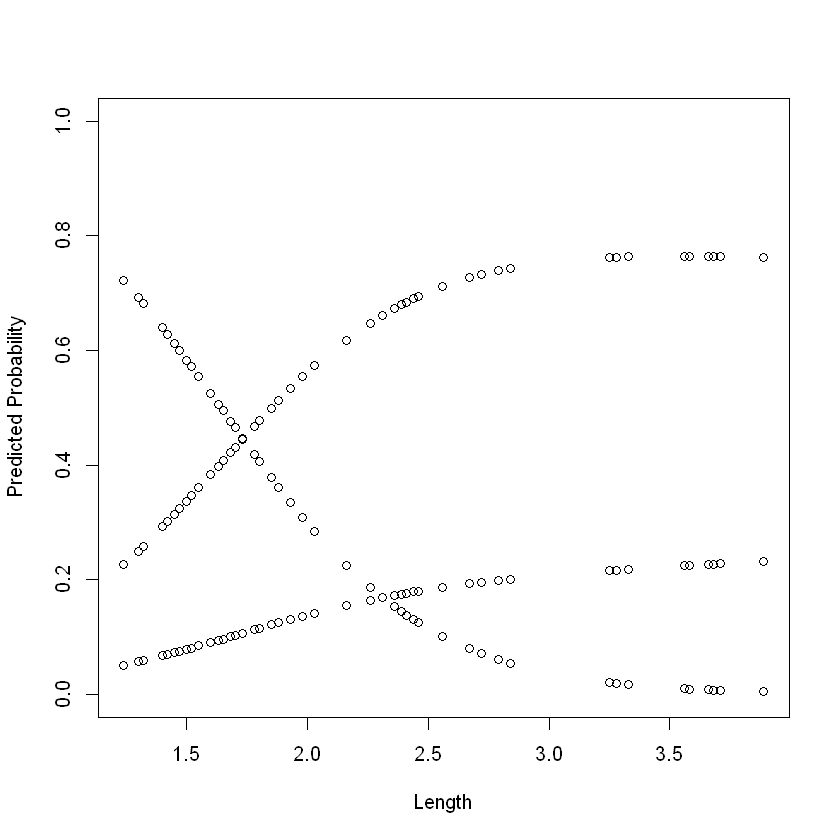

In [34]:
y <- fitted(fit)
plot(Gators$x, y[,1], ylim=c(0,1), ylab="Predicted Probability", xlab="Length")
for (i in 2:3) {
    points(Gators$x, y[,i])
}

### Baseline-catory model with two covariates

Here we have explanatory variables gender $x_1$ and race $x_2$. We indicate the values of each by indicators. The response variable is belief in afterlife, $Y$, with categories yes, undecided, and no (indicated by numbers 1-3).

$$
\log(\pi_j/\pi_3) = \alpha_j + \beta_j^T x, \quad 
\beta_j = \begin{bmatrix} \beta_{gender} \\ \beta_{race} \end{bmatrix}, \ 
x = \begin{bmatrix} \text{gender} \\ \text{race} \end{bmatrix}
$$

In [20]:
Afterlife <- read.table("http://users.stat.ufl.edu/~aa/cat/data/Afterlife.dat",
                        header = TRUE, stringsAsFactors = TRUE)
head(Afterlife)

,race,gender,yes,undecided,no
,<fct>,<fct>,<int>,<int>,<int>
1,white,female,371,49,74
2,white,male,250,45,71
3,black,female,64,9,15
4,black,male,25,5,13


In [22]:
fit <- vglm(
    cbind(yes, undecided, no) ~ gender + race, family=multinomial, data=Afterlife
)
coef(fit)

(Intercept):1 (Intercept):2  gendermale:1  gendermale:2   racewhite:1 
    1.3016026    -0.6529450    -0.4185504    -0.1050638     0.3417744 
  racewhite:2 
    0.2709752

In [23]:
summary(fit)


Call:
vglm(formula = cbind(yes, undecided, no) ~ gender + race, family = multinomial, 
    data = Afterlife)

Coefficients: 
              Estimate Std. Error z value Pr(>|z|)    
(Intercept):1   1.3016     0.2265   5.747  9.1e-09 ***
(Intercept):2  -0.6529     0.3405  -1.918   0.0551 .  
gendermale:1   -0.4186     0.1713  -2.444   0.0145 *  
gendermale:2   -0.1051     0.2465  -0.426   0.6700    
racewhite:1     0.3418     0.2370   1.442   0.1493    
racewhite:2     0.2710     0.3541   0.765   0.4442    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Names of linear predictors: log(mu[,1]/mu[,3]), log(mu[,2]/mu[,3])

Residual deviance: 0.8539 on 2 degrees of freedom

Log-likelihood: -19.7324 on 2 degrees of freedom

Number of Fisher scoring iterations: 3 

No Hauck-Donner effect found in any of the estimates


Reference group is level  3  of the response

In addition to the 6 parameters above, we have 3 additional $\pi_i$'s, ie the individual response probabilities. The total number of parameters is 8, not 9, because $\pi_j = \sum^3_{i, \ i\neq j} \pi_i$. Thus, the model fits 6 of 8 parameters, which means it has $8-6=2$ dofs. This explains the line 

$$\text{Residual deviance} = 0.8539 \sim \chi^2_2$$

To test the effect of gender alone, we drop gender from the model, resulting in 4 dofs. The null hypothesis is $H_0: \ \beta_{1G} = \beta_{2G} = 0$.

In [24]:
fit.race <- vglm(
    cbind(yes, undecided, no) ~ race,
    family=multinomial,
    data=Afterlife
)

deviance(fit.race)

[1] 8.046504

In [25]:
lrtest(fit, fit.race)

Likelihood ratio test

Model 1: cbind(yes, undecided, no) ~ gender + race
Model 2: cbind(yes, undecided, no) ~ race
  #Df  LogLik Df  Chisq Pr(>Chisq)  
1   2 -19.732                       
2   4 -23.329  2 7.1926    0.02742 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

The p-value of 0.027 shows evidence of a gender effect. Males are less likely than females to believe in an afterlife

In [26]:
data.frame(Afterlife$race, Afterlife$gender, fitted(fit))

,Afterlife.race,Afterlife.gender,yes,undecided,no
,<fct>,<fct>,<dbl>,<dbl>,<dbl>
1,white,female,0.7545608,0.09956287,0.1458763
2,white,male,0.6782703,0.12244794,0.1992817
3,black,female,0.7073517,0.10018119,0.1924671
4,black,male,0.6221640,0.12055943,0.2572766


### 6.1.7 Discrete choice models 
- discrete choice models incorporate explanatory variables that are characteristics of the chooser or of the choice
- of the choice, e.g. covariates take on different values for different response categories


Ex. shopping destinations
- five different destinations in different city zones
- two covariates: shopping opportunities $S$, price of trip $P$
- both $S$ and $P$ are characteristics of the choices, rather than shoppers (choosers)
- for any destinations $a$ and $b$, $\log(\pi_a/\pi_b)$, ie odds of choosing $a$ over $b$, does not depend on other laternatives in the choice set or their values in covariates
  - aka independence from irrelevant alternatives

## 6.2 Cumulative logit models for ordinal responses

For response variable  $Y$, the cumulative probability for outcome category $j$ is 
$$
P(Y \leq j) = \sum^c_{i=1} \pi_i
$$
The cumulative probabilities are ordered such that 
$$
P(Y \leq 1) \leq P(Y \leq 2) \leq \cdots \leq P(Y \leq c) = 1
$$
The logits of cumulative probabilities (aka cumulative logits) are 
$$
logit(P(Y \leq j)) = \log \frac{P(Y \leq j)}{1 - P(Y \leq j)} = 
\log \frac{\sum^j_{i=1} \pi_i}{\sum^c_{i=j+1} \pi_i}, \quad j = 1, \dots, c-1 
$$

### 6.2.1 Cumulative logit models with proportional odds 
The cumulative logit model for a particular $j$ looks like a binary logistic regression model, since it creates two partitions: categories $[1,j]$ and categories $[j+1, c]$. 

For a covariate $x$, the model is written as 
$$
logit[P(Y \leq j)] = \alpha_j + \beta x, \quad j = 1, \dots, c-1
$$
where $\beta$ is the same for all $j$. That is, $x$ has the same effect for all $c-1$ cumulative logits. 
- thus, this model only needs **one** parameter to describe the effect of $x$, whereas the baseline-category logit models above required $c-1$. 


The cumulative odds ratio for $x=a$ and $x=b$ is 

$$
\frac{P(Y \le j\ |\ x = a) / P(Y > j\ |\ x = a)}{P(Y \le j\ |\ x = b) / P(Y > j\ |\ x = b)} = 
\frac{P(Y \leq j \mid x=a) P(Y > j \mid x=b)}{P(Y \leq j \mid x=b) P(Y > j \mid x=a)}
$$

- the log of this odds ratio is $\beta (a-b)$, ie difference between the two cumulative logits 
- $\beta$ aka proportional odds, and is the same for all categories
- eg when $a-b=1$,  then a 1-unit increase in $x$ has a $e^\beta$ multiplicative effect on the odds of response below any particular category 

For multiple covariates, the cumulative logit model with the 'proportional odds property' ($\beta$ being the same for all categories) is:
$$
logit[P(Y \leq j)] = \alpha_j + \sum^p_{i=1} \beta_i x_i,
\quad j = 1, \dots, c-1
$$

**Important properties**
- these models have inherent ordinality, which provides greater power, if not simply due to having few(er) dofs
- eg a baseline-category requires parameters for each effect and category, whereas the cumulative logit models require only one per effect. this yields smaller p-values because there is only one degree of freedom for an effect


In [27]:
Polviews <- read.table("http://users.stat.ufl.edu/~aa/cat/data/Polviews.dat",
                        header = TRUE, stringsAsFactors = TRUE)

head(Polviews)                    

,gender,party,y1,y2,y3,y4,y5
,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>
1,female,dem,25,105,86,28,4
2,female,repub,0,5,15,83,32
3,male,dem,20,73,43,20,3
4,male,repub,0,1,14,72,32


Political ideology is encoded by a five-point ordinal scale, $y_1$ through $y_5$. We will define $x_1$ and $x_2$ to be indicator variables of party affiliation (0 for Democrats, 1 for Republicans) and gender (0 for females, 1 for males), respectively.

There are 5 response categories, so we will have 4 intercepts, 5 $\beta$'s, and 4 probabilities. 

In [28]:
fit <- vglm(cbind(y1, y2, y3, y4, y5) ~ party + gender, family=cumulative(parallel=TRUE), data=Polviews)
summary(fit)


Call:
vglm(formula = cbind(y1, y2, y3, y4, y5) ~ party + gender, family = cumulative(parallel = TRUE), 
    data = Polviews)

Coefficients: 
              Estimate Std. Error z value Pr(>|z|)    
(Intercept):1 -2.12234    0.15568 -13.633   <2e-16 ***
(Intercept):2  0.16889    0.09390   1.799   0.0721 .  
(Intercept):3  1.85713    0.12575  14.768   <2e-16 ***
(Intercept):4  4.65001    0.20434  22.757   <2e-16 ***
partyrepub    -3.63361    0.16116 -22.547   <2e-16 ***
gendermale     0.04731    0.10913   0.433   0.6647    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Names of linear predictors: logitlink(P[Y<=1]), logitlink(P[Y<=2]), 
logitlink(P[Y<=3]), logitlink(P[Y<=4])

Residual deviance: 9.8072 on 10 degrees of freedom

Log-likelihood: -35.2032 on 10 degrees of freedom

Number of Fisher scoring iterations: 12 

No Hauck-Donner effect found in any of the estimates


Exponentiated coefficients:
partyrepub gendermale 
0.02642056 1.04844229 

Let a lower number of $Y$ indicate a more liberal political view, e.g. $P(Y \leq 1)$ is extremely liberal, whereas $P(Y > 5)$ is extremely conservative. 

The exponentiated coefficients give us the estimated odds. For fixed $j$,
- the odds that a Republican's response is in the liberal direction $P(Y \leq j)$ versus the conservative direction $P(Y > j)$ is 0.026 times the estimated odds for Democrats. 
  - on the other hand, odds that a Republican is more conservative is $1/0.026 = 37.9$ times the odds that a Democrat is more conservative 


The p-value for gender is large, indicating weak evidence. Regardless of gender, it seems that strong Republicans tend to be much more conservative (much less liberal) than strong Democrats. 

Like the baseline-categoriy logits, the individual cumulative probabilities are 

$$
P(Y \leq j) =
\frac{\exp(\alpha_j + \beta^T x)}{1 + \exp(\alpha_j + \beta^T x)}
$$

For individual response category probabilities, we have 
$$
P(Y = j) = P(Y \leq j) - P(Y \leq j-1)
$$

These are shown below

In [32]:
data.frame(gender, party, fitted(fit))

,gender,party,y1,y2,y3,y4,y5
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,female,dem,0.106944184,0.43517815,0.3228396,0.1255671,0.009470935
2,female,repub,0.003153906,0.02717890,0.1144051,0.5895327,0.265729448
3,male,dem,0.111546923,0.44229233,0.3165534,0.1205701,0.009037294
4,male,repub,0.003306183,0.02844935,0.1189372,0.5927051,0.256602174


### 6.2.3 Inference for cumulative logit model parameters

- null is $H_0: \ \beta_i = 0$, ie remove the effect of a given covariate
- removing political party covariate yields residual deviance of 413, which differs from the full model by 403
- thus, the p-value from a $\chi^2_1$ distribution is nearly 0, which is strong evidence for an effect of political party

In [33]:
fit2 <- vglm(
    cbind(y1, y2, y3, y4, y5) ~ gender, 
    family=cumulative(parallel=TRUE), data=Polviews
)
lrtest(fit, fit2)

Likelihood ratio test

Model 1: cbind(y1, y2, y3, y4, y5) ~ party + gender
Model 2: cbind(y1, y2, y3, y4, y5) ~ gender
  #Df   LogLik Df  Chisq Pr(>Chisq)    
1  10  -35.203                         
2  11 -236.827  1 403.25  < 2.2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Another example relating happiness $Y$ and income $x$. We will treat both as ordinal by grouping income into scores (1,2,3): 

$$
logit[P(Y \leq j)] = \alpha_j + \beta x, \quad j = 1, 2 
$$

To test the significance of income, the null model will be a model with just the intercepts. 

In [34]:
Happy <- read.table("http://users.stat.ufl.edu/~aa/cat/data/Happy.dat",
                    header = TRUE, stringsAsFactors = TRUE)
head(Happy)     

,income,y1,y2,y3
,<int>,<int>,<int>,<int>
1,1,37,90,45
2,2,25,93,56
3,3,6,18,13


In [47]:
fit <- vglm(
    cbind(y1, y2, y3) ~ income, 
    family=cumulative(parallel=TRUE),
    data=Happy
)
fit0 <- vglm(
    cbind(y1, y2, y3) ~ 1,
    family=cumulative(parallel=TRUE),
    data=Happy
)
coef(fit)[3]
lrtest(fit, fit0)

income 
-0.2668456

Likelihood ratio test

Model 1: cbind(y1, y2, y3) ~ income
Model 2: cbind(y1, y2, y3) ~ 1
  #Df  LogLik Df Chisq Pr(>Chisq)  
1   3 -14.566                      
2   4 -16.121  1 3.109    0.07786 .
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

The equivalent baseline-category model would treat both $Y$ and $x$ as nominal when we use indicators for $x$. eg Let $x_1$ and $x_2$ be indicators for income groups 1 and 2. Then, $(x_1, x_2) = (0,0)$ would correspond to being in income group 3. This can be written as 

$$
\log (\pi_j / \pi_3) = \alpha_j + \beta_{j1}x_1 + \beta_{j2}x_2, \quad j=1,2
$$

In [45]:
fit2 <- vglm(
    cbind(y1, y2, y3) ~ factor(income), 
    family=multinomial, data=Happy
)
fit0 <- vglm(
    cbind(y1, y2, y3) ~ 1, 
    family=multinomial, data=Happy 
)
lrtest(fit2, fit0)

Warning message in vglm.fitter(x = x, y = y, w = w, offset = offset, Xm2 = Xm2, :
"some quantities such as z, residuals, SEs may be inaccurate due to convergence at a half-step"


Likelihood ratio test

Model 1: cbind(y1, y2, y3) ~ factor(income)
Model 2: cbind(y1, y2, y3) ~ 1
  #Df  LogLik Df  Chisq Pr(>Chisq)
1   0 -14.058                     
2   4 -16.121  4 4.1258     0.3892

### 6.2.6 Laten variable models imply cumulative link models

The observation of a continuous latent variable may cause it to be seen as discrete. Suppose the latent variable satisfies an ordinary linear model 
$$
Y = \beta^T x + \epsilon
$$
where $\epsilon$ has mean 0 and variance that is indep of $x$. Then,
$$
g[P(Y \leq j)] = \alpha_j - \beta^T x, \quad j = 1, \dots, c-1 
$$
for a link function $g$ that depends on the distribution of $\epsilon$. 

This is aka **cumulative link model**. Here, the link fn is chosen s.t. 
- the $P(Y \leq j)$ has the same shape as the CDF of $\epsilon$, and 
- the $\beta$'s are the same for both the cumulative model and the original ordinary linear model 
- if $\epsilon \sim Normal$, then the link fn is the **probit** link
- if $\epsilon \sim Logistic$, then the link fn is the **logit** link

tl;dr if an ordinary linear model can explain the effects for an underlying latent variable, then it is sensible to use the cumulative logit or probit models with proportional odds 

### 6.2.7 Invariance to response categories

for cumulative logit models, the same parameters occur regardless of how cutpoints are chosen to discretize the response $Y$. Thus, the effect parameters are **invariant** to the choice of response categories. 
- this allows comparing results from studies that use different scales for the response 
- some people collapse ordinal responses to binary to use ordinary logistic regression, but this yields larger standard errors. the loss of efficiency is less severe when going from many categories to 4 or 5, given each category has roughly equal numbers of observations

## 6.3 Cumulative link models: model checking and extensions

### 6.3.2 cumulative logit model without proportional odds 
- proportional odds implies that the distribution of $Y$ for any $x$ is either the same or shifted up/down
  - not valid when response distributions differ in variability, 
  - eg if low income were very polarized and other income groups were moderate; the distributions of happiness would differ between low income and other income groups, but this is inconsistent with proportional odds, which implies that the effect of income is the same for all degrees of happiness 
- the general cumulative logit model has separate effects for different cumulative probabilities, ie different categories 
  - different cumulative probabilities may cross over at certain values of $x$

In [48]:
summary(vglm(
    cbind(y1, y2, y3, y4, y5) ~ party + gender, 
    family=cumulative(parallel=FALSE),
    data=Polviews
))

Warning message in checkwz(wz, M = M, trace = trace, wzepsilon = control$wzepsilon):
"2 diagonal elements of the working weights variable 'wz' have been replaced by 1.819e-12"



Call:
vglm(formula = cbind(y1, y2, y3, y4, y5) ~ party + gender, family = cumulative(parallel = FALSE), 
    data = Polviews)

Coefficients: 
                Estimate Std. Error z value Pr(>|z|)    
(Intercept):1 -2.175e+00  1.990e-01 -10.931  < 2e-16 ***
(Intercept):2  1.217e-01  1.097e-01   1.110    0.267    
(Intercept):3  1.888e+00  1.498e-01  12.602  < 2e-16 ***
(Intercept):4  4.104e+00  3.761e-01  10.912  < 2e-16 ***
partyrepub:1  -3.637e+01  5.243e+05   0.000    1.000    
partyrepub:2  -3.943e+00  3.921e-01 -10.056  < 2e-16 ***
partyrepub:3  -3.681e+00  2.056e-01 -17.901  < 2e-16 ***
partyrepub:4  -2.945e+00  3.859e-01  -7.631 2.33e-14 ***
gendermale:1   2.183e-01  3.025e-01   0.722    0.470    
gendermale:2   1.834e-01  1.706e-01   1.075    0.282    
gendermale:3  -8.638e-02  1.995e-01  -0.433    0.665    
gendermale:4  -1.463e-01  2.624e-01  -0.558    0.577    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Names of linear predictors: logitlink(P[Y<=1]), 

The effect of Republican party membership on the first cumulative logit has a huge standard error, whereas the actual MLE is $-\infty$. This occurs due to **quasi-complete separation**: the marginal table relating party affiliation to political ideology has nearly zero very liberal Republicans, so the effect of being a Republican on political views cannot be estimated. 

In [60]:
xtabs(cbind(y1, y2, y3, y4, y5) ~ party, Polviews)

       
party    y1  y2  y3  y4  y5
  dem    45 178 129  48   7
  repub   0   6  29 155  64

### 6.3.4 Modeling mental impairment
- $Y$ = mental impairment, ordinal with categories 1-4, increasing in severity
- $x_1$ = life events index, a measure of the number and severity of important life events
- $x_2$ = socioeconomic status, binary with low=0 and high=1

We use a latent variable induced form of the cumulative logit model with proportional odds:
$$
logit[P(Y \leq j)] = \alpha_j - \beta^T x
$$

In [63]:
Mental <- read.table("http://users.stat.ufl.edu/~aa/cat/data/Mental.dat",
                        header = TRUE, stringsAsFactors = TRUE)

head(Mental)

,impair,ses,life
,<int>,<int>,<int>
1,1,1,1
2,1,1,9
3,1,1,0
4,1,1,4
5,1,1,3
6,1,0,2


In [66]:
library(MASS, help, pos = 2, lib.loc = NULL)

# polr function requires response to be a factor
y <- factor(Mental$impair)  

fit <- polr(y ~ life + ses, method="logistic", data=Mental)

summary(fit)


Re-fitting to get Hessian




Call:
polr(formula = y ~ life + ses, data = Mental, method = "logistic")

Coefficients:
       Value Std. Error t value
life  0.3189     0.1210   2.635
ses  -1.1112     0.6109  -1.819

Intercepts:
    Value   Std. Error t value
1|2 -0.2819  0.6423    -0.4389
2|3  1.2128  0.6607     1.8357
3|4  2.2094  0.7210     3.0644

Residual Deviance: 99.0979 
AIC: 109.0979 

Note the 't-values' are actually z-scores.

In [67]:
predict(fit, data.frame(ses=0, life=mean(Mental$life)), type="probs")
predict(fit, data.frame(ses=1, life=mean(Mental$life)), type="probs")

1         2         3         4 
0.1617811 0.3007047 0.2372921 0.3002222

1         2         3         4 
0.3696301 0.3536702 0.1529587 0.1237410

The cell above computes probabilities $P(Y =i)$ for given levels of SES at *mean* life events. 
- at low SES, $P(Y=4) = 0.300$, but $P(Y=4)=0.124$ at high SES 

We can repeat the above for max and min life events to see how, e.g. $P(Y=4)$ changes at high SES from min to max life events. 

In [68]:
predict(fit, data.frame(ses=1, life=min(Mental$life)), type="probs")
predict(fit, data.frame(ses=1, life=max(Mental$life)), type="probs")

1          2          3          4 
0.69621280 0.21463441 0.05428168 0.03487110

1         2         3         4 
0.1150236 0.2518325 0.2439856 0.3891584

Rate of change in estimated probability per unit change in life events

```r
$ME.1
     effect std.error z.value p.value
life -0.057     0.019  -3.005   0.003
ses   0.198     0.104   1.913   0.056

$ME.4
     effect std.error z.value p.value
life  0.048     0.017   2.780   0.005
ses  -0.171     0.094  -1.819   0.069

attr(,"class")
[1] "ocAME"
```

### 6.3.5 Latent variable probability comparison

We can compare latent variables $y_1*$ and $y_2*$ that underlie responses for two groups, ie $P(Y_2* > Y_1*)$. 

$$
P(Y_2* > Y_1*) = \frac{\exp(\beta/\sqrt{2})}{1 + \exp(\beta/\sqrt{2})}
$$

### 6.3.6 Cumulative probit model

In [79]:
Polviews2 <- read.table("http://users.stat.ufl.edu/~aa/cat/data/Polviews2.dat",
                        header = TRUE, stringsAsFactors = TRUE)

head(Polviews2)

,subject,gender,party,ideology
,<int>,<fct>,<fct>,<int>
1,1,female,dem,1
2,2,female,dem,1
3,3,female,dem,1
4,4,female,dem,1
5,5,female,dem,1
6,6,female,dem,1


In [80]:
y <- factor(Polviews2$ideology)
fit.probit <- polr(y ~ party + gender, method="probit", data=Polviews2)
summary(fit.probit)


Re-fitting to get Hessian




Call:
polr(formula = y ~ party + gender, data = Polviews2, method = "probit")

Coefficients:
               Value Std. Error  t value
partyrepub  2.032496    0.10996 18.48409
gendermale -0.007489    0.08562 -0.08747

Intercepts:
    Value    Std. Error t value 
1|2  -1.2353   0.0890   -13.8853
2|3   0.1033   0.0694     1.4901
3|4   1.0532   0.0808    13.0376
4|5   2.6171   0.1194    21.9153

Residual Deviance: 1565.195 
AIC: 1577.195 

The effect of Republican party membership is $\beta_1 = 2.03$. 
- the estimated mean political ideology for Republicans is 2.03x higher than that for Democrats
- the two groups' means differ by 2.03 stdevs 

### 6.3.7 $R^2$ for the latent variable model

We can summarize predictive power for a cumulative link model by approximating $R^2$ for the latent variable model. Let $y_i*$ be the value of the latent variable for subject $i$. Then,

$$
R^2_L = \frac{\sum_i (\hat{y}_i^* - E[y^*])^2}{\sum_i (y_i^* - E[y^*])^2} = \frac{var(\hat{y}^*)}{var(y^*)}
$$

The denominator, $var(y^*)$, is unknown, but we approximate it as $var(y^*) = var(\hat{y}^*) + var(e)$, where $e$ is the residual error in the latent variable model.
- for the standard normal distribution, $e=1$
- for the standard logistic distribution, $e = \pi^2/3 = 3.29$

In [89]:
fit.logit <- polr(y ~ party + gender, method="logistic", data=Polviews2)
v <- var(fit.logit$lp) / (var(fit.logit$lp) + (pi^2)/3)
v

[1] 0.4869847

Multiple correlation based on logistic latent variable model

In [83]:
sqrt(v)

[1] 0.6978429

$R^2$ for normal latent variable model for cumulative probit

In [87]:
v2 <- var(fit.probit$lp) / (var(fit.probit$lp) + 1)
v2; sqrt(v2)

[1] 0.494531

[1] 0.703229

- 48.7% of the variability in the political ideology latent variable is explained by the two explanatory variables, political ideology and gender
  - bc we use extreme categories of party affiliation (strong Dem/Rep), which predict ideology well
- $R^2 = 0.487$ using just party affiliation

## 6.4 Paired Category Logit Modelling of Ordinal Responses

### 6.4.1 Adjacent-Categories Logits
Like baseline-category, but uses logits between adjacent categories rather than baseline
$$
\log \frac{\pi_j}{\pi_{j+1}} = \alpha_j + \beta x, \quad 
j = 1, \dots, c-1
$$

**Properties**
- With proportional odds form, there is only one $\beta$ for all categories $j$. 
- uses the ordering of response scale, since $\log(\pi_a / \pi_b) = (\alpha_a - \alpha_b) + \beta(a-b)$, i.e. magnitude of effect depends on distance between categories being compared

In [90]:
head(Polviews)

,gender,party,y1,y2,y3,y4,y5
,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>
1,female,dem,25,105,86,28,4
2,female,repub,0,5,15,83,32
3,male,dem,20,73,43,20,3
4,male,repub,0,1,14,72,32


We will use an adjacent-categories logit model to explain political ideology with $x_1$ as party affiliation and $x_2$ as gender

$$
\log \frac{\pi_j}{\pi_{j+1}} =
\alpha_j + \beta_1 x_1 + \beta_2 x_2, \quad 
j = 1,2,3,4
$$

In [91]:
fit <- vglm(
    cbind(y1,y2,y3,y4,y5) ~ party + gender, 
    family=acat(parallel=TRUE, reverse=TRUE), data=Polviews
)
summary(fit)


Call:
vglm(formula = cbind(y1, y2, y3, y4, y5) ~ party + gender, family = acat(parallel = TRUE, 
    reverse = TRUE), data = Polviews)

Coefficients: 
              Estimate Std. Error z value Pr(>|z|)    
(Intercept):1 -1.38707    0.17079  -8.121 4.61e-16 ***
(Intercept):2  0.36218    0.11749   3.083  0.00205 ** 
(Intercept):3  0.77529    0.14720   5.267 1.39e-07 ***
(Intercept):4  2.99240    0.23132  12.936  < 2e-16 ***
partyrepub    -2.23478    0.16841 -13.270  < 2e-16 ***
gendermale     0.01212    0.09661   0.125  0.90016    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Names of linear predictors: loglink(P[Y=1]/P[Y=2]), loglink(P[Y=2]/P[Y=3]), 
loglink(P[Y=3]/P[Y=4]), loglink(P[Y=4]/P[Y=5])

Residual deviance: 13.4665 on 10 degrees of freedom

Log-likelihood: -37.0329 on 10 degrees of freedom

Number of Fisher scoring iterations: 4 

'partyrepub'


Party affiliation effect has coefficient $-2.235$: 
- estimated odds that a Republican's views are in category $j$ vs $j+1$ are $\exp(-2.235)$ times the dods for Democrats
  - aka **local odds ratio** bc indicates effect for a localized part of the response scale

For arbitrary pair of columns, the estimated odds ratio is $\exp[\beta_1(b-a)]$.

### 6.4.3 Seuqential logits
Another approach uses the following logits
$$
\log \frac{\pi_1}{\sum^c_{i=2} \pi_i}, \cdots , 
\log \frac{\pi_j}{\sum^c_{i=j+1} \pi_i}, \cdots, 
\log \frac{\pi_{c-1}}{\pi_c}
$$
- sequential aka continuation-ratio logits
- eg when sequential mechanism, eg survival, determines response outcome

Sequential logits are logits of conditional probabilities
$$
\begin{align}
w_j &= P(Y = j \mid Y \geq j) \\
\log \frac{\pi_j}{\sum^c_{i=j+1} \pi_i} &= logit(w_j) \\
&= \log \frac{w_j}{1-w_j}
\end{align}
$$

In [95]:
library(dplyr, help, pos = 2, lib.loc = NULL)
Tonsils <- tibble(carrier = c("yes", "no"), y1 = c(19, 497), 
                  y2 = c(29, 560), y3 = c(24, 269))

Tonsils

carrier,y1,y2,y3
<chr>,<dbl>,<dbl>,<dbl>
yes,19,29,24
no,497,560,269


The data above cross-classify a sample of children by their tonsil size and whether they carry streptococcus pyogenes.
- response = tonsil size, categorized in 3 ordered outcomes

Sequential logits are natural choice bc of the sequential mechanism by which tonsils will enlarge upon infection. 
- sequential logits can model, eg
  - P(normal size) = $\pi_1$, and 
  - P(enlarged | enlarged or greatly enlarged) = $\frac{\pi_2}{\pi_2 + \pi_3}$

Let $x$ be the indicator of strep infection. The sequential model with proportional odds is 
$$
\begin{align}
\log \frac{\pi_1}{\pi_2+\pi_3} &= \alpha_1 + \beta x \\
\log \frac{\pi_2}{\pi_3} &= \alpha_2 + \beta x 
\end{align}
$$

In [96]:
fit <- vglm(
    cbind(y1, y2, y3) ~ carrier, 
    family = sratio(parallel=TRUE),
    data = Tonsils
)
summary(fit)


Call:
vglm(formula = cbind(y1, y2, y3) ~ carrier, family = sratio(parallel = TRUE), 
    data = Tonsils)

Coefficients: 
              Estimate Std. Error z value Pr(>|z|)    
(Intercept):1 -0.51102    0.05614  -9.102  < 2e-16 ***
(Intercept):2  0.73218    0.07286  10.049  < 2e-16 ***
carrieryes    -0.52846    0.19775  -2.672  0.00753 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Names of linear predictors: logitlink(P[Y=1|Y>=1]), logitlink(P[Y=2|Y>=2])

Residual deviance: 0.0057 on 1 degrees of freedom

Log-likelihood: -11.7659 on 1 degrees of freedom

Number of Fisher scoring iterations: 3 

No Hauck-Donner effect found in any of the estimates


In [97]:
fitted(fit)

,y1,y2,y3
1,0.2612503,0.4068696,0.3318801
2,0.3749547,0.4220828,0.2029625


There is strong evidence of association, eg
- $\beta = -0.523$ and $\exp(-0.529) = 0.59$ means that, given that tonsils were larger than normal (categories 2 or 3), the odds for strep carriers of having normal sized tonsils was 0.59x the odds for non-carriers 
- accordingly, the fitted values of probabilities in the cell above show that carriers are more likely to have very large tonsils, although both carriers and non-carriers are roughly equally likely to have larger-than-normal tonsils

# References
[raymondbalise](https://raymondbalise.github.io/Agresti_IntroToCategorical/Multicategory.html#example-modeling-mental-impairment)